<a href="https://colab.research.google.com/github/albertocj1/CCMACLRL_EXERCISES_COM222/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [381]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [382]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [383]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [384]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [385]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [386]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [387]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [388]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [389]:
duplicate_rows = df_train[df_train.duplicated()]
print("Duplicate Rows : \n", duplicate_rows)

Duplicate Rows : 
 Empty DataFrame
Columns: [text, label]
Index: []


5. Check how many rows belong to each class

In [390]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [391]:
df_train.drop_duplicates(inplace = True)

7. Remove rows with NaN values

In [392]:
df_train.dropna(inplace = True)

8. Convert all text to lowercase

In [393]:
df_train['text'] = df_train['text'].str.lower()

9. Remove digits, URLS and special characters

In [394]:
def remove_digits_urls_special_chars(text):
  text = re.sub(r'\d+', '', text)  # Remove digits
  text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
  text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
  return text

df_train['text'] = df_train['text'].apply(remove_digits_urls_special_chars)
df_validation['text'] = df_validation['text'].apply(remove_digits_urls_special_chars)
df_test['text'] = df_test['text'].apply(remove_digits_urls_special_chars)

10. Remove stop words

In [395]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# List of common Filipino stop words
filipino_stopwords = [
    'ang', 'sa', 'ng', 'mga', 'si', 'ni', 'kay', 'ay', 'at', 'na',
    'ngayon', 'dito', 'saan', 'kanino', 'ngunit', 'dahil', 'kung',
    'kahit', 'lahat', 'ito', 'iyan', 'iyon', 'kasi', 'nang', 'para',
    'paano', 'rin', 'din', 'ba', 'pa', 'wala', 'may', 'niya', 'ako',
    'ikaw', 'kami', 'tayo', 'sila', 'mo', 'ko', 'akin', 'amin', 'atin',
    'kanila', 'maging', 'napaka', 'isa', 'tungkol', 'bawat', 'muli'
]

def remove_stopwords(text, language='english'):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    if language == 'english':
        filtered_tokens = [word for word in tokens if word.lower() not in set(stopwords.words('english'))]
    elif language == 'filipino':
        filtered_tokens = [word for word in tokens if word.lower() not in filipino_stopwords]
    else:
        raise ValueError("Unsupported language. Please use 'english' or 'filipino'.")

    return " ".join(filtered_tokens)

    df_train['text'] = df_train['text'].apply(remove_stopwords)
    df_validation['text'] = df_validation['text'].apply(remove_stopwords)
    df_test['text'] = df_test['text'].apply(remove_stopwords)


11. Use Stemming or Lemmatization

In [396]:

def stem_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()

    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

    df_train['text'] = df_train['text'].apply(stem_text)
    df_validation['text'] = df_validation['text'].apply(stem_text)
    df_test['text'] = df_test['text'].apply(stem_text)

## C. Training your model

12. Put all text training data in variable **X_train**

In [397]:
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [398]:
Y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [399]:
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [400]:
model = MultinomialNB()

16. Train the model using `.fit()`

In [401]:
model.fit(X_train_transformed, Y_train)

MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [402]:
X_validation = df_test['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [408]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.49892857142857144
Precision: 0.504
Recall: 0.5342756183745583
F1-Score: 0.518696397941681


19. Create a confusion matrix using the **validation dataset**

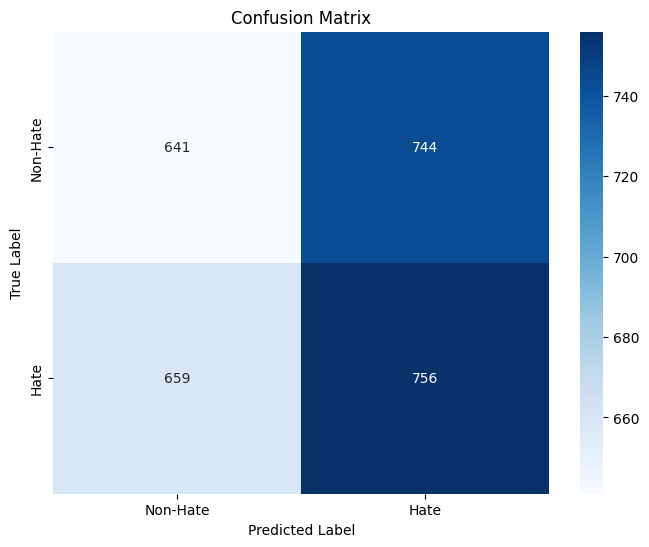

In [409]:
cm = confusion_matrix(y_validation, y_validation_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [410]:
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [411]:
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8334519572953737
Precision: 0.8087649402390438
Recall: 0.871244635193133
F1-Score: 0.8388429752066116


22. Create a confusion matrix using the **test dataset**

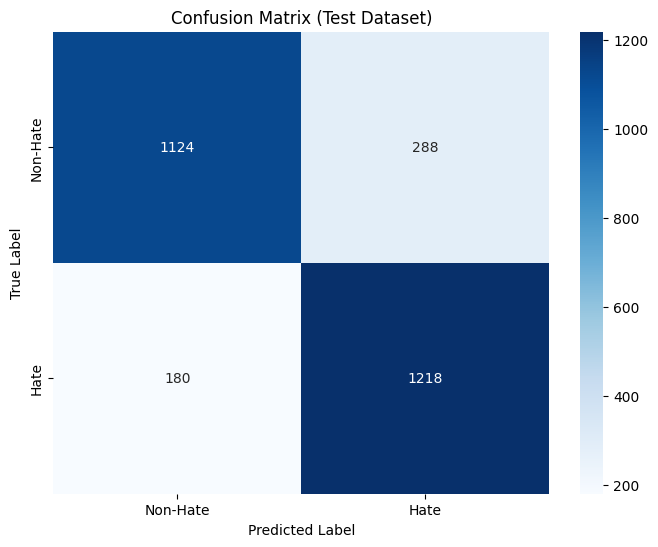

In [412]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Dataset)')
plt.show()


## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [413]:
def try_model():
    new_input = input("Input: ")
    new_input_transformed = vectorizer.transform([new_input])
    prediction = model.predict(new_input_transformed)
    print(f"Prediction for '{new_input}': {prediction[0]}")

try_model()


Input: ang sarap mabuhay
Prediction for 'ang sarap mabuhay': 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [414]:
try_model()

Input: ang panget mo naman
Prediction for 'ang panget mo naman': 1
